# 多自由度系统的动力学分析

这个笔记本展示了如何使用Python进行多自由度系统的动力学分析，采用文学式编程的方式，将理论与代码结合起来。

## 导入必要的库

我们首先需要导入一些Python库，用于数值计算和可视化：
- NumPy：用于处理矩阵和数值计算
- SciPy：用于求解常微分方程
- Matplotlib：用于数据可视化

In [14]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## 定义多自由度系统的参数

我们将考虑一个简单的三自由度系统，如三个质量块通过弹簧连接的系统。需要定义的参数包括：
- 质量矩阵 M
- 阻尼矩阵 C
- 刚度矩阵 K
- 初始位移和速度条件

In [15]:
# 系统参数定义
# 三个质量块的质量
m1, m2, m3 = 1.0, 1.5, 2.0
# 四个弹簧的刚度
k1, k2, k3, k4 = 2.0, 3.0, 3.0, 2.5
# 阻尼系数
c1, c2, c3, c4 = 0.1, 0.2, 0.2, 0.1

# 构建质量矩阵、阻尼矩阵和刚度矩阵
M = np.diag([m1, m2, m3])  # 质量矩阵（对角矩阵）

# 刚度矩阵
K = np.array([
    [k1+k2, -k2, 0],
    [-k2, k2+k3, -k3],
    [0, -k3, k3+k4]
])

# 阻尼矩阵
C = np.array([
    [c1+c2, -c2, 0],
    [-c2, c2+c3, -c3],
    [0, -c3, c3+c4]
])

# 初始条件
x0 = np.array([0.1, 0.0, 0.0])  # 初始位移
v0 = np.array([0.0, 0.0, 0.0])  # 初始速度

# 合并初始状态 [x1, x2, x3, v1, v2, v3]
initial_state = np.concatenate((x0, v0))

print("质量矩阵 M:")
print(M)
print("\n刚度矩阵 K:")
print(K)
print("\n阻尼矩阵 C:")
print(C)
print("\n初始状态:")
print(f"位移: {x0}")
print(f"速度: {v0}")

质量矩阵 M:
[[1.  0.  0. ]
 [0.  1.5 0. ]
 [0.  0.  2. ]]

刚度矩阵 K:
[[ 5.  -3.   0. ]
 [-3.   6.  -3. ]
 [ 0.  -3.   5.5]]

阻尼矩阵 C:
[[ 0.3 -0.2  0. ]
 [-0.2  0.4 -0.2]
 [ 0.  -0.2  0.3]]

初始状态:
位移: [0.1 0.  0. ]
速度: [0. 0. 0.]


## 建立系统的运动方程

多自由度系统的运动方程可以表示为：

$$M\ddot{x} + C\dot{x} + Kx = F(t)$$

其中：
- $M$ 是质量矩阵
- $C$ 是阻尼矩阵
- $K$ 是刚度矩阵
- $F(t)$ 是外力向量
- $x$ 是位移向量
- $\dot{x}$ 是速度向量
- $\ddot{x}$ 是加速度向量

为了求解这个二阶微分方程组，我们将其转换为一阶微分方程组：

$$\begin{bmatrix} \dot{x} \\ \ddot{x} \end{bmatrix} = 
\begin{bmatrix} 
0 & I \\
-M^{-1}K & -M^{-1}C
\end{bmatrix}
\begin{bmatrix} x \\ \dot{x} \end{bmatrix} +
\begin{bmatrix} 0 \\ M^{-1}F(t) \end{bmatrix}$$

下面，我们定义一个函数来表示这个一阶微分方程组。

In [16]:
def system_dynamics(t, state, M, C, K, F_func):
    """
    描述多自由度系统动力学的一阶微分方程组
    
    参数:
    t : 时间
    state : 系统状态 [x, v] 其中 x 是位移, v 是速度
    M : 质量矩阵
    C : 阻尼矩阵
    K : 刚度矩阵
    F_func : 外力函数，接收时间t作为输入
    
    返回:
    dstate_dt : 状态导数 [v, a] 其中 v 是速度, a 是加速度
    """
    n = len(M)
    x = state[:n]  # 位移
    v = state[n:]  # 速度
    
    # 计算外力
    F = F_func(t)
    
    # 计算加速度: a = M^(-1) * (F - C*v - K*x)
    a = np.linalg.solve(M, F - C.dot(v) - K.dot(x))
    
    dstate_dt = np.concatenate((v, a))
    return dstate_dt

# 定义外力函数
def external_force(t):
    """
    外力函数，此处我们定义一个简单的正弦激励力，只作用在第一个质量上
    """
    force = np.zeros(3)
    if t < 10:  # 在前10秒施加力
        force[0] = 0.5 * np.sin(2*t)  # 正弦力作用在第一个质量上
    return force

## 求解运动方程

接下来，我们使用SciPy的`solve_ivp`函数来数值求解这个微分方程组。这将给出系统的位移和速度随时间的变化。

In [17]:
# 设置时间范围
t_start = 0.0
t_end = 20.0
t_span = (t_start, t_end)
t_eval = np.linspace(t_start, t_end, 1000)  # 求解评估点

# 求解微分方程
solution = solve_ivp(
    lambda t, y: system_dynamics(t, y, M, C, K, external_force),
    t_span,
    initial_state,
    t_eval=t_eval,
    method='RK45'
)

# 提取结果
t = solution.t
n = len(M)
x = solution.y[:n, :]  # 位移
v = solution.y[n:, :]  # 速度

# 计算加速度
a = np.zeros_like(x)
for i in range(len(t)):
    F = external_force(t[i])
    a[:, i] = np.linalg.solve(M, F - C.dot(v[:, i]) - K.dot(x[:, i]))

print(f"求解完成，共 {len(t)} 个时间点")

求解完成，共 1000 个时间点


## 可视化系统的动力学行为

现在，我们将绘制系统的位移、速度和加速度随时间的变化曲线，以及创建一个动画来可视化质量块的运动。

/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/1243019180.py:27: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/1243019180.py:27: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/1243019180.py:27: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/1243019180.py:27: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/1243019180.py:27: UserWarning: Glyph 30001 (\N{CJK UNIFIED IDEOGRAPH-7531}) missing from current font.
  plt.tight_layout()
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3

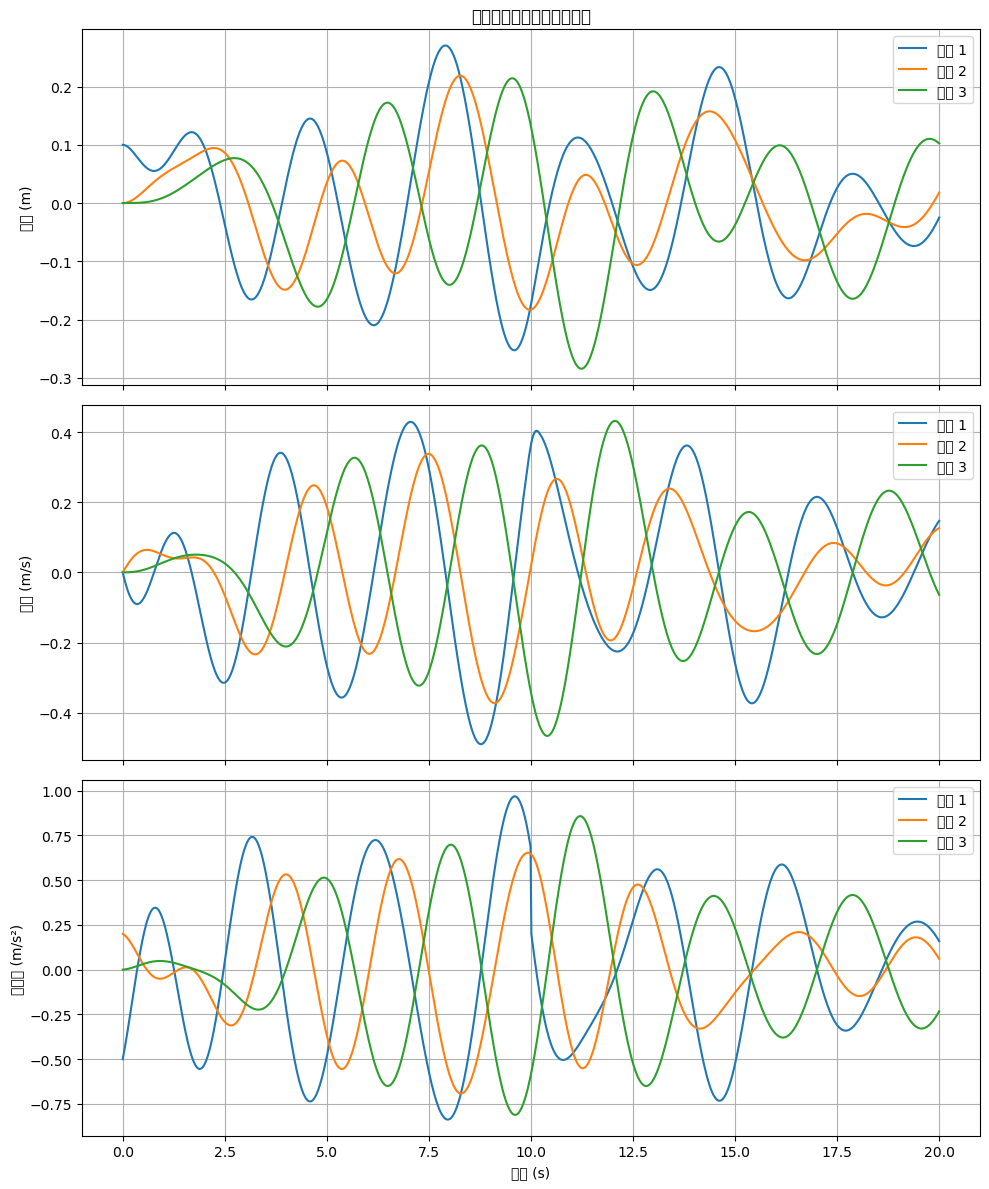

In [18]:
# 创建一个3x1的子图，分别显示位移、速度和加速度
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# 位移图
for i in range(n):
    axs[0].plot(t, x[i, :], label=f'质量 {i+1}')
axs[0].set_ylabel('位移 (m)')
axs[0].set_title('多自由度系统的动力学响应')
axs[0].grid(True)
axs[0].legend()

# 速度图
for i in range(n):
    axs[1].plot(t, v[i, :], label=f'质量 {i+1}')
axs[1].set_ylabel('速度 (m/s)')
axs[1].grid(True)
axs[1].legend()

# 加速度图
for i in range(n):
    axs[2].plot(t, a[i, :], label=f'质量 {i+1}')
axs[2].set_xlabel('时间 (s)')
axs[2].set_ylabel('加速度 (m/s²)')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [19]:
# 创建系统运动的动画
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-2, 5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('位置 (m)')
ax.set_title('多自由度系统运动动画')
ax.grid(True)

# 创建质量块的表示
base = plt.Rectangle((-2, -0.1), 0.4, 0.2, color='gray')
m1_rect = plt.Rectangle((x[0, 0], -0.15), 0.3, 0.3, color='blue')
m2_rect = plt.Rectangle((x[1, 0], -0.15), 0.3, 0.3, color='green')
m3_rect = plt.Rectangle((x[2, 0], -0.15), 0.3, 0.3, color='red')

# 将矩形添加到图中
ax.add_patch(base)
ax.add_patch(m1_rect)
ax.add_patch(m2_rect)
ax.add_patch(m3_rect)

# 创建弹簧线的表示
spring1, = ax.plot([], [], 'k-', lw=1)
spring2, = ax.plot([], [], 'k-', lw=1)
spring3, = ax.plot([], [], 'k-', lw=1)
spring4, = ax.plot([], [], 'k-', lw=1)

# 时间文本
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

# 初始化函数
def init():
    m1_rect.set_xy((x[0, 0], -0.15))
    m2_rect.set_xy((x[1, 0], -0.15))
    m3_rect.set_xy((x[2, 0], -0.15))
    
    spring1.set_data([], [])
    spring2.set_data([], [])
    spring3.set_data([], [])
    spring4.set_data([], [])
    
    time_text.set_text('')
    
    return base, m1_rect, m2_rect, m3_rect, spring1, spring2, spring3, spring4, time_text

# 更新函数
def update(frame):
    # 更新质量块位置
    m1_rect.set_xy((x[0, frame], -0.15))
    m2_rect.set_xy((x[1, frame], -0.15))
    m3_rect.set_xy((x[2, frame], -0.15))
    
    # 更新弹簧线
    # 基座到质量1
    spring1.set_data([-1.6, x[0, frame]], [0, 0])
    
    # 质量1到质量2
    spring2.set_data([x[0, frame]+0.3, x[1, frame]], [0, 0])
    
    # 质量2到质量3
    spring3.set_data([x[1, frame]+0.3, x[2, frame]], [0, 0])
    
    # 质量3到固定点
    spring4.set_data([x[2, frame]+0.3, 5], [0, 0])
    
    # 更新时间文本
    time_text.set_text(f'时间: {t[frame]:.2f}s')
    
    return base, m1_rect, m2_rect, m3_rect, spring1, spring2, spring3, spring4, time_text

# 创建动画
# 为了让动画更流畅，我们选择每隔几个帧取一个
frame_interval = 5
frames = range(0, len(t), frame_interval)

ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)

plt.close()  # 防止显示静态图像

# 为了在Jupyter中显示动画，我们需要使用HTML
# 注意: 在Jupyter中才能正常显示，在其他环境中可能需要其他方法保存或显示动画
from IPython.display import HTML
HTML(ani.to_jshtml())

/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/3718149578.py:75: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/3718149578.py:75: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/3718149578.py:75: UserWarning: Glyph 30001 (\N{CJK UNIFIED IDEOGRAPH-7531}) missing from current font.
  ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)
/var/folders/tm/snrp8gcn00113mpkf_j5jmqm0000gn/T/ipykernel_3910/3718149578.py:75: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  ani = FuncAnimation(fig, update, frames=frames, init_func=in

## 结论

通过这个分析，我们演示了如何：

1. 建立多自由度系统的动力学模型
2. 将二阶微分方程转换为一阶方程组
3. 使用数值方法求解运动方程
4. 可视化系统的动力学行为

这种方法可以应用于各种多自由度系统，如结构振动、机械系统动力学分析等。通过改变系统的参数（质量、刚度、阻尼）或外力条件，可以研究不同配置下系统的动态响应。

## 拓展练习

1. 尝试更改系统参数（质量、刚度、阻尼）并观察对系统响应的影响
2. 实现不同类型的外力函数，如阶跃力、脉冲力或随机激励
3. 计算系统的自然频率和模态形状
4. 实现模态分析并将运动分解为不同模态的叠加
5. 扩展模型到更多自由度